In [6]:
import ast
import numpy as np
import time
import sys
import pandas as pd
import subprocess
import pickle
import random as rand
import matplotlib.pyplot as plt
import time
import math
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
%config InlineBackend.figure_format='retina'

In [2]:
# Google Colab
%cd "drive/My Drive/internship-2020"

/content/drive/My Drive/internship-2020


In [7]:
from flt3_data_loading import km_normed_1, flt3_filtered

# Test split sizes (add up to 1)
train_size = 0.6
valid_size = 0.2
test_size = 0.2

# Separating out negatives & positives
negatives = []
positives = []
for pat_i in range(len(km_normed_1)):
    if flt3_filtered[pat_i] == 1:
        if len(positives) == 0:
            positives = np.concatenate((positives, np.array(km_normed_1.iloc[pat_i])))
        else:
            positives = np.vstack((positives, np.array(km_normed_1.iloc[pat_i])))
    elif flt3_filtered[pat_i] == 0:
        if len(negatives) == 0:
            negatives = np.concatenate((negatives, np.array(km_normed_1.iloc[pat_i])))
        else:
            negatives = np.vstack((negatives, np.array(km_normed_1.iloc[pat_i])))

# Splitting sets
num_pos = len(positives)
num_neg = len(negatives)
sum_sizes = train_size + valid_size + test_size
ps1, ps2 = math.floor(train_size*num_pos), math.floor((train_size+valid_size)*num_pos)
ns1, ns2 = math.floor(train_size*num_neg), math.floor((train_size+valid_size)*num_neg)
train_set = np.concatenate((negatives[:ns1], positives[:ps1]))
valid_set = np.concatenate((negatives[ns1:ns2], positives[ps1:ps2]))
test_set = np.concatenate((negatives[ns2:], positives[ps2:]))
n_neg_train, n_neg_val, n_neg_test = ns1, (ns2-ns1), (num_neg-ns2)
n_pos_train, n_pos_val, n_pos_test = ps1, (ps2-ps1), (num_pos-ps2)
train_label = [0] * n_neg_train + [1] * n_pos_train
valid_label = [0] * n_neg_val + [1] * n_pos_val
test_label = [0] * n_neg_test + [1] * n_pos_test

# Oversample each set
n_extra_pos_train, n_extra_pos_val, n_extra_pos_test = n_neg_train-n_pos_train, n_neg_val-n_pos_val, n_neg_test-n_pos_test
over_train = np.array([]).reshape((0,km_normed_1.shape[1]))
over_valid = np.array([]).reshape((0,km_normed_1.shape[1]))
over_test = np.array([]).reshape((0,km_normed_1.shape[1]))
i,j,k = 0,0,0
while len(over_train) < n_extra_pos_train:
    over_train = np.concatenate((over_train, train_set[n_neg_train + i % n_pos_train].reshape(1,km_normed_1.shape[1])))
    train_label += [1]
    i += 1
while len(over_valid) < n_extra_pos_val:
    over_valid = np.concatenate((over_valid, valid_set[n_neg_val + j % n_pos_val].reshape(1,km_normed_1.shape[1])))
    valid_label += [1]
    j += 1
while len(over_test) < n_extra_pos_test:
    over_test = np.concatenate((over_test, test_set[n_neg_test + k % n_pos_test].reshape(1,km_normed_1.shape[1])))
    test_label += [1]
    k += 1
oc_train_set = np.concatenate((train_set, over_train))
oc_valid_set = np.concatenate((valid_set, over_valid))
oc_test_set = np.concatenate((test_set, over_test))

train_and_label = [(oc_train_set[i],train_label[i]) for i in range(len(train_label))]
valid_and_label = [(oc_valid_set[i],valid_label[i]) for i in range(len(valid_label))]
test_and_label = [(oc_test_set[i],test_label[i]) for i in range(len(test_label))]

# Data samplers & loaders
batch_size = 64
num_workers = 0
train_sampler = SubsetRandomSampler(range(len(train_and_label)))
valid_sampler = SubsetRandomSampler(range(len(valid_and_label)))
test_sampler = SubsetRandomSampler(range(len(test_and_label)))
train_loader = torch.utils.data.DataLoader(train_and_label,
                                           batch_size=batch_size,
                                           sampler=train_sampler,
                                           num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_and_label,
                                           batch_size=batch_size,
                                           sampler=valid_sampler,
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_and_label,
                                           batch_size=batch_size,
                                           sampler=test_sampler,
                                           num_workers=num_workers)

In [8]:
print(train_set.shape)
print(valid_set.shape)
print(test_set.shape)
print(ns1, ns2, ps1, ps2)
print(len(oc_train_set),len(oc_valid_set),len(oc_test_set))
print(len(train_label), len(valid_label), len(test_label))
print(train_label[ns1])

(271, 3796)
(90, 3796)
(91, 3796)
192 256 79 105
384 128 128
384 128 128
1


Epoch: 1000	Train: 0.2187784935037295	Val: 1.17024564743042	Min Val: 0.6930986642837524
tensor([0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
        0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1])
tensor([0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1])
tensor([0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1])
tensor([0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
        0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1])

 0.4921798631476051
tensor([0, 1, 0, 1, 1, 

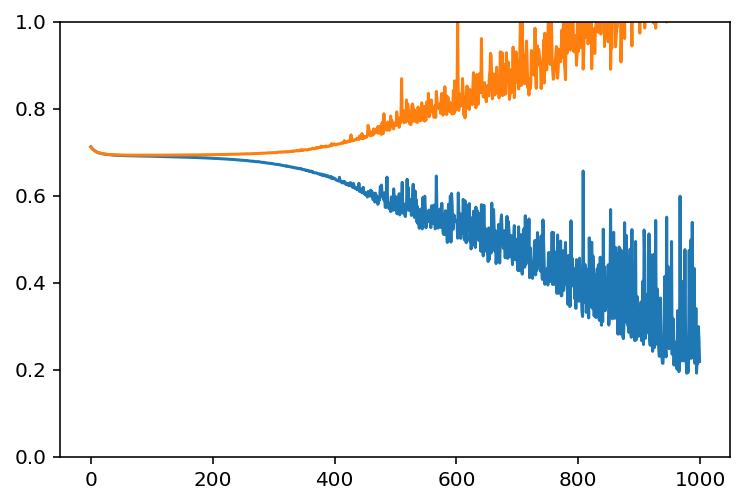

In [5]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"
device = torch.device(dev)

# 4 layers sgd lr=0.01 and no dropout
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(km_normed_1.shape[1], 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 8)
        self.fc5 = nn.Linear(8, 2)
        #self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = self.dropout(x)
        x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = F.relu(self.fc3(x))
        #x = self.dropout(x)
        x = F.relu(self.fc4(x))
        #x = self.dropout(x)
        x = self.fc5(x)
        return x
    
    def predict(self,x):
        pred = F.softmax(self.forward(x), dim=1)
        ans = []
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

n_epochs = 1000
valid_loss_min = np.Inf
t_losses = []
v_losses = []

model = Net()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    # Training
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data.float())
        target = target.long()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # Validation
    model.eval()
    for data, target in valid_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data.float())
        target = target.long()
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    # Saving loss for validation graph
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    t_losses.append(train_loss)
    v_losses.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        torch.save(model.state_dict(), 'model_files/model_flt3_0.pt')
        valid_loss_min = valid_loss
    
    # Progress bar
    print(f"\rEpoch: {epoch+1}\tTrain: {train_loss}\tVal: {valid_loss}\tMin Val: {valid_loss_min}", end='')
print("")
torch.save(model.state_dict(), 'model_files/model_flt3_0.pt')

# Final model
model.load_state_dict(torch.load('model_files/model_flt3_0.pt'))
from sklearn.metrics import roc_auc_score
model.eval()
score = 0
for data, target in test_loader:
    data = data.to(device)
    pred = model.predict(data.float())
    pred.cpu()
    score += roc_auc_score(pred, target)*len(target)
    #print(roc_auc_score(pred, target))
    print(pred)
    print(target)
print('\n', score/len(test_loader.sampler))

# Saved best model
model.load_state_dict(torch.load('model_files/model_flt3_0.pt'))
model.eval()
score = 0
for data, target in test_loader:
    data = data.to(device)
    data.float()
    pred = model.predict(data.float())
    pred.cpu()
    score += roc_auc_score(pred, target)*len(target)
    #print(roc_auc_score(pred, target))
    print(pred)
    print(target)
print('\n', score/len(test_loader.sampler))

# Validation graph
plt.plot(t_losses)
plt.plot(v_losses)
plt.ylim(0,1)
plt.show()